# 비지도학습

In [1]:
from matplotlib import font_manager, rc 
import matplotlib as mpl
font_path = "C:\\Users\\이혜림\\Desktop\\Bita5/malgun.ttf" 
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc("font",family=font_name)
mpl.rcParams["axes.unicode_minus"]=False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import os

## DBSCAN
- 밀집된 연속적 지역을 클러스터로 정의
- 모든 클러스터가 충분히 밀집되어 있고, 밀집되지 않은 지역과 잘 구분될 때 잘 작동
- 계산복잡도 : O(mlogm)
    - 각 데이터에 대해서 m개에 데이터에 대해 거리를 계산해야 함
    - 사이킷런 : O(m2) -> eps가 커지는 경우(핵심샘플이 다른 핵심샘플의 이웃에 포함되는 경우가 많아지기 때문에, 이러한 경우를 탐색해주어야 함 -> 시간이 더 걸림)

<작동방식>
1. 각 샘플에서 작은 거리(입실론) 내에 샘플이 몇 개 놓여있는지 카운트,
    - 입실론 이웃 : 해당 샘플의 입실론 거리 내의 구역
1. 입실론 이웃 내에 적어도 min_samples개의 샘플이 있다면(자기 자신을 포함해) 이를 핵심 샘플로 간주.
    - 핵심 샘플 : 밀집된 지역(min_samples 이상의 밀집)에 있는 샘플
1. 핵심 샘플의 이웃에 있는 모든 샘플을 동일한 클러스터, 이웃에 다른 핵심 샘플이 포함될 수 있음. 따라서 핵심 샘플의 이웃의 이웃은 계속해서 하나의 클러스터를 형성
1. 핵심 샘플이 아니고 이웃도 아닌 샘플은 이상치
    - 이상치는 라벨을 -1로 반환

- 적절히 군집이 이루어질 수 있도록 epsilon 과 min_samples를 설정해주어야 함
    - 과하게 클러스터 -> epsilon을 더 크게
    - 적은 클러스터 -> epsilon을 더 작게

### DBSCAN 장점

1. 이상치의 영향을 덜 받고 안정적
1. 클러스터의 모양과 개수에 상관없이 감지할 수 있음
    - kmeans의 경우 클러스터가 동그래야 잘 감지, 하이퍼파라미터로 k를 설정해 주어야 함
1. 클러스터 간의 밀집도가 크게 다르게 되면, 모든 클러스터를 올바르게 잡아내는 것이 불가능
    - 밀집도가 낮은 것에 맞춘 경우 : eps 크게 -> 밀도 높은 클러스터에서 오류가 발생
    - 밀집도가 높은 것에 맞춘 경우 : epx 낮게 -> 밀도 낮은 클러스터에서 오류가 발생

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 1000, noise = 0.05)
dbscan = DBSCAN(eps = 0.05, min_samples = 5) # epsilon = 0.05로 선택, min_samples = 5로 선택
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [32]:
print(dbscan.labels_[:10]) # 각 데이터에 할당된 라벨
print(dbscan.core_sample_indices_[:10]) # 핵심샘플의 인덱스
print(dbscan.components_) # 핵심샘플의 데이터

# 주의해야할 점 : 각 핵심샘플마다 레이블이 되는 것이 아님.
# 어떠한 핵심샘플의 이웃에 다른 핵심샘플이 포함되면 같은 라벨을 가짐 

[2 0 1 1 0 0 0 2 1 3]
[ 1  3  4  5  6  7  8  9 11 12]
[[-0.78305446  0.56841735]
 [ 0.08770149  0.15935642]
 [-0.91334562  0.42018725]
 ...
 [ 0.84877367  0.38831379]
 [ 0.02610439  0.14065404]
 [-0.48499887  0.85313405]]


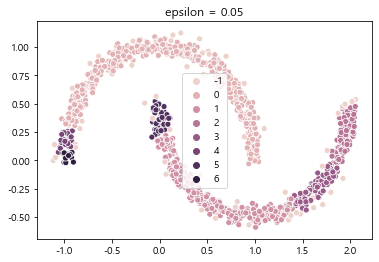

In [33]:
plt.title("epsilon = 0.05")
sns.scatterplot(x=X[:,0], y=X[:,1], hue = dbscan.labels_, legend="full")
# 모든 legend를 표시하도록 설정

# -> 데이터를 의도보다 더 촘촘하게 labeling -> epsilon을 좀더 넓힘으로써 적은 labeling

Text(0.5, 1.0, 'epsilon = 0.2')

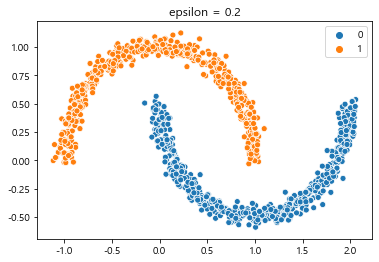

In [34]:
dbscan = DBSCAN(eps=0.2, min_samples = 5)
sns.scatterplot(X[:,0], X[:,1], hue=dbscan.fit(X,y).labels_)
plt.title("epsilon = 0.2")

DBSCAN은 새로운 데이터에 대한 예측을 할 수 없음.  
- 엡실론 안에 min_samples 만큼의 샘플이 있으면 핵심 샘플.
- 만약 핵심 샘플들과의 거리를 계산하여 핵심샘플의 앱실론 거리 안에 들어가면 해당 라벨을 부여할 수도 있겠지만, 새로운 샘플이 들어옴으로써 기존 데이터의 앱실론 이웃의 샘플 개수가 변할 수도 있음.
- 따라서 이것은 fit_predict 이지 단순한 predict가 아님  
=> DBSCAN은 fit_predict만 존재

### DBSCAN으로 데이터 전처리 후 예측  
<훈련 데이터 선택 방법> - 최종 작업의 성능에 따라 결정
1. 핵심샘플만으로 훈련을 진행할 수도(대표성이 있는 샘플)
2. 전체 데이터에 대해서 진행할 수도
3. 이상치를 제거하고 진행할 수도 있음

In [40]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(50) # 가장 가까운 50개의 이웃을 선택하여 라벨 예측
# k개수가 많아질 수록 결정경계가 단순화, 일반화에 용이하게 됨

# 핵심샘플 만으로 훈련
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [42]:
X_new = np.array([[-0.5,0],[0,0.5],[1,-0.1],[2,1]])
print(knn.predict(X_new))
print(knn.predict_proba(X_new))

[1 0 1 0]
[[0.18 0.82]
 [1.   0.  ]
 [0.18 0.82]
 [1.   0.  ]]


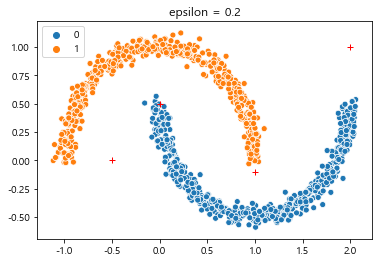

In [59]:
sns.scatterplot(X[:,0], X[:,1], hue=dbscan.fit(X,y).labels_)
plt.title("epsilon = 0.2")
plt.plot(X_new[:,0],X_new[:,1], "or", marker="+")

#### KNN에서 이상치 분류하기

In [69]:
# 데이터에서 가장 가까운 1개의 데이터, 인덱스 반환
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors = 1)

# 핵심 샘플을 train set으로 넣었기 때문에, 핵심 샘플만을 추출한 후에, 가장 가까운 샘플들을 반환
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist>0.2] = -1 # 가장 가까운 거인데도 거리가 0.2보다 크다는 것은 이상치일 확률이 있음
y_pred.ravel() # 배열을 펼침

array([-1,  0,  1, -1], dtype=int64)

## 다른 군집 알고리즘

1. 병합 군집
    - 클러스터 계층을 밑바닥부터 위로 쌓아 구성
    - 연결 행렬을 통해 인접한 클러스터 쌍을 연결. 각 클러스터마다 이진 트리를 구성
        - 연결 행렬: 각 샘플간의 거리일 수도, 혹은 다른 것일 수도 있음
    - 대규모 샘플과 클러스터에 잘 확장되며 다양한 형태의 클러스터를 감지할 수 잇음
    - 특정 클러스터 개수를 선택하는 데에도 유용.

2. BIRCH
    - 대규모 데이터셋을 위해 고안됨
    - 특성 개수가 너무 많지 않다면(20개 이하) 배치 k-평균보다 빠르고 비슷한 결과를 만듦
    - 새로운 샘플을 클러스터에 빠르게 할당할 수 잇는 정보를 담은 트리 구조를 만듦
    - 제한된 메모리를 사용하여 대용량 데이터셋을 만듦

3. 평균-이동
    - 국부적인 밀집도 추정에 의존.
    - 각 샘플을 중심으로 하는 원을 그린 후, 원마다 안에 포함된 모든 샘플의 평균을 구한다.
    - 그 후 원의 중심을 평균점으로 이동시킴. 모든 원이 움직이지 않을 때까지 평균-이동을 계속함
    - 원은 최대밀도를 찾을 때까지 높은 쪽으로 원을 이동시킴. 동일한 지역(또는 충분히 가깝게) 안착한 원에 있는 모든 샘플은 동일한 클러스터.
    - 모양이나 개수에 관계없이 클러스터를 찾을 수 있음
    - 하이퍼 파라미터 : 밴스위스(원반경)
    - 클러스터 내부 밀집도가 불균형할 때, 여러개로 나누는 경향이 있음.
        - DBSCAN의 경우 하나의 이웃만 있으면 그 이웃의 클러스터를 따라가면 되지만, 평균-이동 같은 경우는 모든 원이 밀집도가 높은 쪽으로 이동하려고 하기 때문
    - 계산복잡도 : $O(m^{2})$ -> 대규모 데이터셋에 적합하지 않음

4. 유사도 전파
    - 각 샘플은 자신을 대표할 수 있는 비슷한 샘플에 투표
    - 알고리즘이 수렴하면 각 대표와 투표한 샘플이 클러스터를 형성
    - 크기가 다른 여러 개의 클러스터를 감지할 수 있음
    - 계산복잡도 : $O(m^{2})$ -> 대규모 데이터셋에 적합하지 않음

5. 스펙트럼 군집
    - 샘플 사이의 유사도 행렬을 받아 저차원 임베딩을 만듦(차원 축소)
    - 저차원 공간에서 군집 알고리즘을 사용
    - 샘플 개수가 많으면 잘 적용되지 않고, 클러스터의 크기가 매우 다르면 잘 작동하지 않음.
    - 복잡한 클러스터 구조를 감지하고 그래프 컷을 찾는 데 사용할 수 있음(소셜 네트워크에서 친구의 클러스터를 찾는 데 사용할 수 잇음)